Baseado no artigo:
[SIMPLE CNN AND VGGISH MODEL
FOR HIGH-LEVEL SOUND CATEGORIZATION
WITHIN THE MAKING SENSE OF SOUNDS CHALLENGE](https://cvssp.org/projects/making_sense_of_sounds/site/assets/challenge_abstracts_and_figures/Patrice_Guyot_3.pdf
)

Esse Notebook possui:


1.   Modelo SimpleMind
2.   Modelo ResNet


In [ ]:
import os
import pylab
import shutil
import matplotlib
import numpy as np
import librosa.display
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from IPython.display import display, Audio

In [ ]:
DATASET_ROOT = os.path.join(os.path.expanduser("~"), "/content/drive/MyDrive/Colab Notebooks/sound_spec")

In [ ]:
train_subfolder = "train"
test_subfolder = "test"
valid_subfolder = "validation"

DATASET_TRAIN_PATH = os.path.join(DATASET_ROOT, train_subfolder)
DATASET_TEST_PATH = os.path.join(DATASET_ROOT, test_subfolder)
DATASET_VALID_PATH = os.path.join(DATASET_ROOT, valid_subfolder)

In [ ]:
DATASET_TRAIN_PATH

'/content/drive/MyDrive/Colab Notebooks/sound_spec/train'

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class_names = ['Effects', 'Human', 'Music', 'Nature', 'Urban']

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 /255)
test_datagen = ImageDataGenerator(rescale = 1.0 /255)
pred_datagen = ImageDataGenerator(rescale = 1.0 /255)

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/sound_spec/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/sound_spec/test"
pred_dir = "/content/drive/MyDrive/Colab Notebooks/sound_spec/validation"

In [ ]:
train_generator = train_datagen.flow_from_directory(base_dir,batch_size=20,class_mode='categorical', shuffle=True, target_size=(432,288))
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=20,class_mode='categorical', shuffle=True, target_size=(432,288))
pred_generator = pred_datagen.flow_from_directory(pred_dir,batch_size=20,class_mode='categorical', shuffle=True, target_size=(432,288))

Found 1350 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 500 images belonging to 1 classes.


# Abaixo serão mostrados 2 modelos para comparação de desempenho, sendo eles:


1.   SimpleMind
2.   ResNet





1. Modelo SimpleMind

In [ ]:
#Modelo simplemind proposto no artigo
'''
• convolution (filter size=3×3, depth=64)
• max pooling (filter size=3×5)
• convolution (filter size=1×3, depth=32)
• convolution (filter size=3×3, depth=32)
• convolution (filter size=1×3, depth=32)
• max pooling (filter size=3×5)
• convolution (filter size=3×3, depth=32)
• max pooling (filter size=2×2)
• dropout (rate=0.2)
• dense (128 units)
• dropout (rate=0.2)
• dense (5 units)'''

model = models.Sequential()
model.add(layers.Conv2D(64,(3,3), activation="relu",input_shape=(432,288,3)))
model.add(layers.MaxPooling2D((2,3)))
model.add(layers.Conv2D(32,(1,3), activation="relu"))
model.add(layers.Conv2D(32,(3,3), activation="relu"))
model.add(layers.Conv2D(32,(1,3), activation="relu"))
model.add(layers.MaxPooling2D((3,5)))
model.add(layers.Conv2D(32,(3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(5,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 430, 286, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 215, 95, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 215, 93, 32)       6176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 213, 91, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 213, 89, 32)       3104      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 17, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 15, 32)        9

Modelo ResNet50

In [ ]:
#Modelo ResNet 
from keras.applications.resnet50 import ResNet50
model_res = ResNet50( include_top=False, input_shape=(432,288,3))

flatten = layers.Flatten()
new_layer = layers.Dense(512, activation='relu', name='my_dense')
new_layer_2 = layers.Dense(5, activation='softmax', name='my_dense_2')

inp_res = model_res.input

out_res = new_layer(flatten(model_res.output))
model_res = keras.Model(inp_res, out_res)

out_res = new_layer_2(flatten(model_res.output))
model_res = keras.Model(inp_res, out_res)

model_res.summary(line_length=150)

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 432, 288, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)                        (None, 438, 294, 3)              0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv1_conv (

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_res.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
model_save_filename = "model.h5"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

In [ ]:
history = model.fit(train_generator, validation_data=test_generator, epochs=40, verbose=1)

Epoch 1/40
68/68 [==============================] - 603s 8s/step - loss: 1.5389 - accuracy: 0.2861 - val_loss: 1.4502 - val_accuracy: 0.3733
Epoch 2/40
68/68 [==============================] - 8s 123ms/step - loss: 1.3906 - accuracy: 0.4040 - val_loss: 1.2233 - val_accuracy: 0.4800
Epoch 3/40
68/68 [==============================] - 8s 120ms/step - loss: 1.2213 - accuracy: 0.4783 - val_loss: 1.3043 - val_accuracy: 0.4267
Epoch 4/40
68/68 [==============================] - 8s 121ms/step - loss: 1.1404 - accuracy: 0.5221 - val_loss: 1.1244 - val_accuracy: 0.5400
Epoch 5/40
68/68 [==============================] - 8s 121ms/step - loss: 0.9086 - accuracy: 0.6422 - val_loss: 1.0334 - val_accuracy: 0.6000
Epoch 6/40
68/68 [==============================] - 8s 122ms/step - loss: 0.7938 - accuracy: 0.6854 - val_loss: 1.1757 - val_accuracy: 0.5800
Epoch 7/40
68/68 [==============================] - 8s 120ms/step - loss: 0.7268 - accuracy: 0.7248 - val_loss: 1.2040 - val_accuracy: 0.6067
Epoch 8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


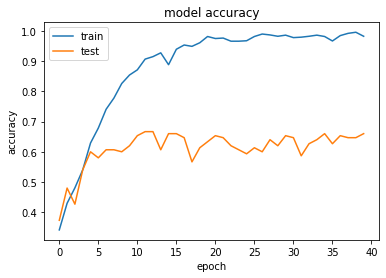

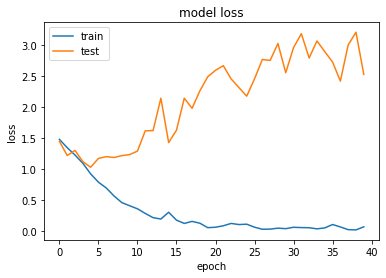

In [ ]:
import matplotlib.pyplot as plt
import numpy
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history_res = model_res.fit(train_generator, validation_data=test_generator, epochs=40, verbose=1)

Epoch 1/40
68/68 [==============================] - 26s 316ms/step - loss: 12.0015 - accuracy: 0.3996 - val_loss: 1.8377 - val_accuracy: 0.2000
Epoch 2/40
68/68 [==============================] - 20s 293ms/step - loss: 0.7038 - accuracy: 0.7333 - val_loss: 2.0183 - val_accuracy: 0.2067
Epoch 3/40
68/68 [==============================] - 20s 293ms/step - loss: 0.2830 - accuracy: 0.8985 - val_loss: 2.6898 - val_accuracy: 0.2000
Epoch 4/40
68/68 [==============================] - 20s 292ms/step - loss: 0.1412 - accuracy: 0.9560 - val_loss: 2.1962 - val_accuracy: 0.2000
Epoch 5/40
68/68 [==============================] - 20s 292ms/step - loss: 0.0493 - accuracy: 0.9901 - val_loss: 2.7363 - val_accuracy: 0.2000
Epoch 6/40
68/68 [==============================] - 20s 292ms/step - loss: 0.0331 - accuracy: 0.9922 - val_loss: 3.3617 - val_accuracy: 0.2000
Epoch 7/40
68/68 [==============================] - 20s 293ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 3.6405 - val_accuracy: 0.220

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


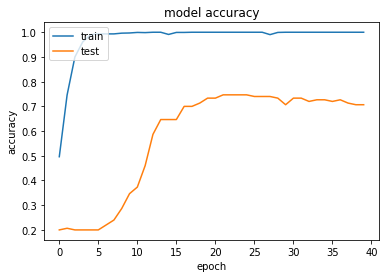

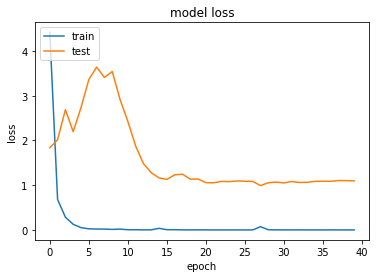

In [ ]:
import matplotlib.pyplot as plt
import numpy
print(history_res.history.keys())
# summarize history for accuracy
plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resultados

Resultado do Modelo SimpleMind

In [ ]:
print(model.evaluate(test_generator)[1])

8/8 [==============================] - 1s 92ms/step - loss: 2.5316 - accuracy: 0.6600
0.6600000262260437


Resultado do Modelo ResNet

In [ ]:
print(model_res.evaluate(test_generator)[1])

8/8 [==============================] - 1s 109ms/step - loss: 1.0969 - accuracy: 0.7067
0.7066666483879089


In [ ]:
gui = len(pred_generator)

In [ ]:
predict = model_res.predict_generator(pred_generator,gui)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
cl = np.round(predict)
filenames=pred_generator.filenames

In [ ]:
np.argmax(predict[0])
filenames[0]

'validation/029.wav.jpg'

In [ ]:
for i in range(gui):
  filenames[i] = filenames[i].replace('.jpg','')
  filenames[i] = filenames[i].replace('validation/','')
path_list = []
for i in range(gui):
  path_list.append("/content/drive/MyDrive/Colab Notebooks/sound/validation/"+filenames[i])


In [ ]:
import ffmpeg
import wave

In [ ]:
#Import pra número aleatórios
from random import seed
from random import randint
seed(1)
import ffmpeg
import IPython

In [ ]:
for _ in range(3):
  value = randint(0, 24)
  name = path_list[value]
  print("The Sound Label is  " + class_names[np.argmax(predict[value])])
  IPython.display.Audio(name)

The Sound Label is  Human
The Sound Label is  Music
The Sound Label is  Urban


In [ ]:
print("The Sound Label is  " + class_names[np.argmax(predict[5])])
IPython.display.Audio(path_list[5])

The Sound Label is  Human


In [ ]:
print("The Sound Label is  " + class_names[np.argmax(predict[8])])
IPython.display.Audio(path_list[8])

The Sound Label is  Urban


In [ ]:
print("The Sound Label is  " + class_names[np.argmax(predict[17])])
IPython.display.Audio(path_list[17])

The Sound Label is  Nature


In [ ]:
print("The Sound Label is  " + class_names[np.argmax(predict[21])])
IPython.display.Audio(path_list[21])

The Sound Label is  Music
